In [46]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch
import torch.nn as nn
import scipy
import operator

Try to get a digital filter that approximates measured impedance response using least squares regression. Start from digital filter obtained from bilinear of equivalent circuit.

Text(0, 0.5, 'Rad')

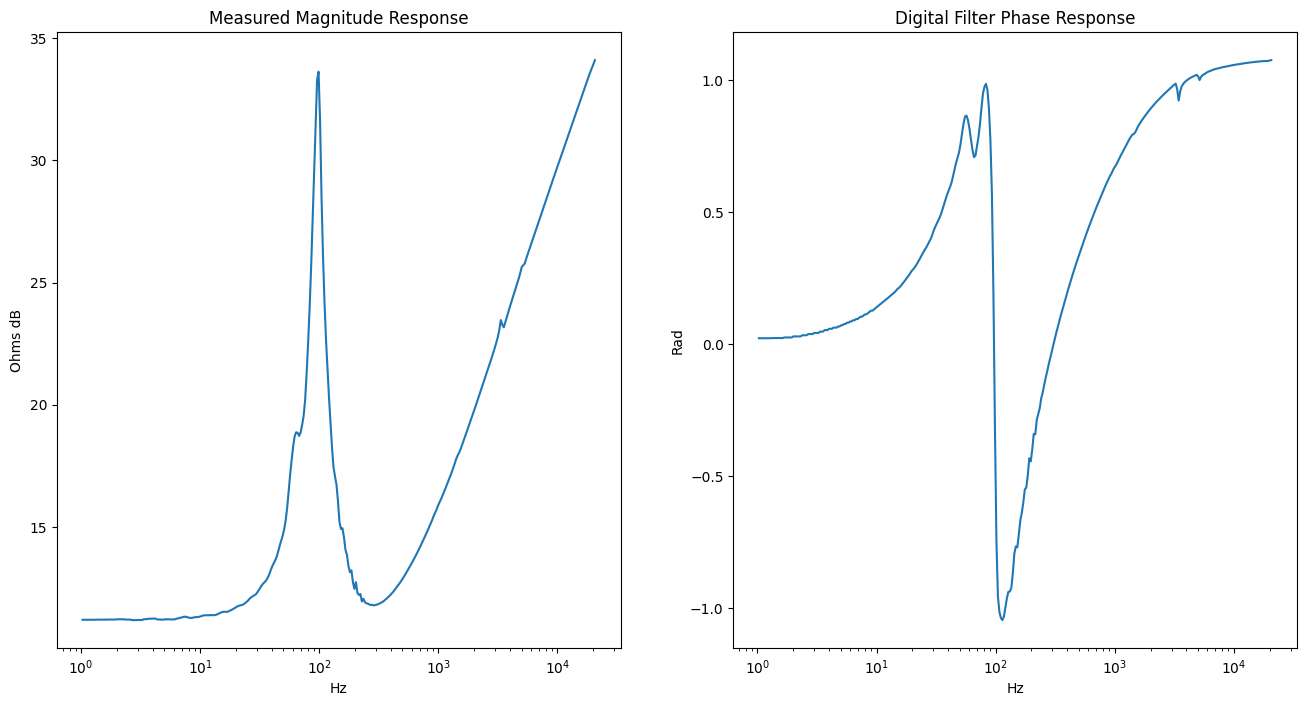

In [47]:
#Measured Response
datastart = 0
f = []
h_measured = []

with open('A1_0g_Data.txt') as file:
    for line in file:
        if(datastart):
            linesplit = line.split('\t')
            f.append(float(linesplit[0]))
            h_measured.append(float(linesplit[1]) * np.exp(1j * float(linesplit[2]) * np.pi / 180))
        if(line[0:4] == 'Freq'):
            datastart = 1

f = np.array(f)
h_measured = np.array(h_measured)

plt.figure(figsize=(16, 8)) 
plt.subplot(1, 2, 1)
plt.plot(f , 20*np.log10(np.abs(h_measured)))
plt.xscale('log')
plt.title('Measured Magnitude Response')
plt.xlabel("Hz")
plt.ylabel("Ohms dB")

plt.subplot(1, 2, 2)
plt.plot(f, np.angle(h_measured))
plt.xscale('log')
plt.title('Digital Filter Phase Response')
plt.xlabel("Hz")
plt.ylabel("Rad")

In [48]:
#Params for equivalent circuit
#From the datasheet or DATS measurement
# Voice Coil: EX32VBDS-4
R_e = 3.6
L_e = 0.43e-3
f_res = 85.4
T_s = 1 / 2 / np.pi / f_res
Q_e = 0.8534
Q_m = 10.78

#Derived values
L = R_e * T_s / Q_e
R = R_e * Q_m / Q_e
C = T_s * Q_e / R_e

w = f * 2 * np.pi
fs = 44100

In [117]:
#Circuit Simulation Impedance
Z = R_e + 1j*w*L_e + 1/((1/(1j*w*L)) + (1/R) + 1j*w*C)

# Impedance Response to Analog Filter. (Equation derived by hand)
b = [L_e*L*R*C, L_e*L+L*R*C*R_e, L*R + L*R_e+R*L_e, R_e*R]
a = [L*R*C, L, R]

bz, az = signal.bilinear(b, a, fs)
bz, az

#Analog filter to digital filter
wz, hz_bilinear = signal.freqz(bz, az, worN = f, fs = fs)

Text(0, 0.5, 'Rad')

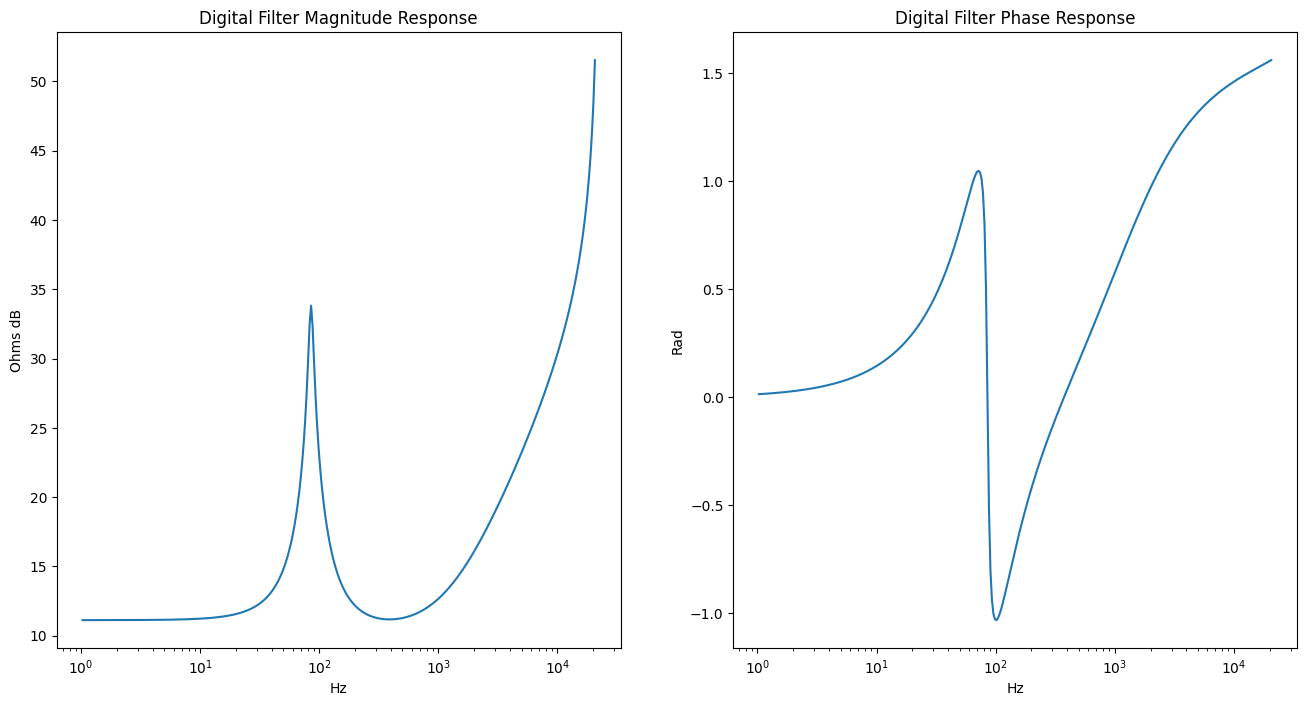

In [118]:
plt.figure(figsize=(16, 8)) 
plt.subplot(1, 2, 1)
plt.plot(f, 20*np.log10(np.abs(hz_bilinear)))
plt.xscale('log')
plt.title('Digital Filter Magnitude Response')
plt.xlabel("Hz")
plt.ylabel("Ohms dB")

plt.subplot(1, 2, 2)
plt.plot(f, np.angle(hz_bilinear))
plt.xscale('log')
plt.title('Digital Filter Phase Response')
plt.xlabel("Hz")
plt.ylabel("Rad")

In [77]:
def polyval_torch(x, c, tensor=True):
      c0 = c.clone().detach()[-1]
      for i in range(2, len(c) + 1):
            c0 = c[-i] + c0*x
      return c0

def freqz_torch(b, a=1, f=0, fs=2*np.pi):
      w = 2*np.pi*f/fs

      zm1 = torch.tensor(np.exp(-1j * w))
      h = (polyval_torch(zm1, b, tensor=False) /
            polyval_torch(zm1, a, tensor=False))

      w = w*(fs/(2*np.pi))

      return w, h


In [215]:
epochs = 2000
lr = 1e-7

class IIR(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.nn.Parameter(torch.randn((3, 1)))
        self.b = torch.nn.Parameter(torch.randn((3, 1)))

    def forward(self, x):
        return signal.lfilter(b, a, x)

#Define loss and optimizer
def loss(bz, az, h_measured, weights=None):
    _, hz = freqz_torch(bz, az, f = f, fs = fs)
    #nnloss = nn.L1Loss()
    unweighted_loss = torch.abs(torch.square((hz - h_measured)))
    if(weights==None):
        return torch.mean(unweighted_loss)
    return torch.mean(unweighted_loss * weights)

model = IIR()
model.b = torch.nn.Parameter(torch.tensor(bz))
model.a = torch.nn.Parameter(torch.tensor(az))
model.b = torch.nn.Parameter(torch.nn.functional.pad(model.b, (0, 10), "constant", 0))
model.a = torch.nn.Parameter(torch.nn.functional.pad(model.a, (0, 10), "constant", 0))

printevery = 100
weights = 1/np.diff(f)
weights = np.pad(weights, (0, 1), 'edge')
weights = torch.tensor(weights)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


#Run training
for epoch in range(epochs+1):
    l = loss(model.b, model.a, torch.tensor(h_measured))
    l.backward()
    if(epoch % printevery == 0):
        print(epoch, l)
    #Update weights
    optimizer.step()
    optimizer.zero_grad()
print(model.a)
print(model.b)


0 tensor(15.7351, dtype=torch.float64, grad_fn=<MeanBackward0>)
100 tensor(3.0554, dtype=torch.float64, grad_fn=<MeanBackward0>)
200 tensor(2.1874, dtype=torch.float64, grad_fn=<MeanBackward0>)
300 tensor(1.9215, dtype=torch.float64, grad_fn=<MeanBackward0>)
400 tensor(1.8420, dtype=torch.float64, grad_fn=<MeanBackward0>)
500 tensor(1.8116, dtype=torch.float64, grad_fn=<MeanBackward0>)
600 tensor(1.7929, dtype=torch.float64, grad_fn=<MeanBackward0>)
700 tensor(1.7786, dtype=torch.float64, grad_fn=<MeanBackward0>)
800 tensor(1.7674, dtype=torch.float64, grad_fn=<MeanBackward0>)
900 tensor(1.7586, dtype=torch.float64, grad_fn=<MeanBackward0>)
1000 tensor(1.7519, dtype=torch.float64, grad_fn=<MeanBackward0>)
1100 tensor(1.7469, dtype=torch.float64, grad_fn=<MeanBackward0>)
1200 tensor(1.7432, dtype=torch.float64, grad_fn=<MeanBackward0>)
1300 tensor(1.7405, dtype=torch.float64, grad_fn=<MeanBackward0>)
1400 tensor(1.7385, dtype=torch.float64, grad_fn=<MeanBackward0>)
1500 tensor(1.7370, d

Text(0, 0.5, 'Rad')

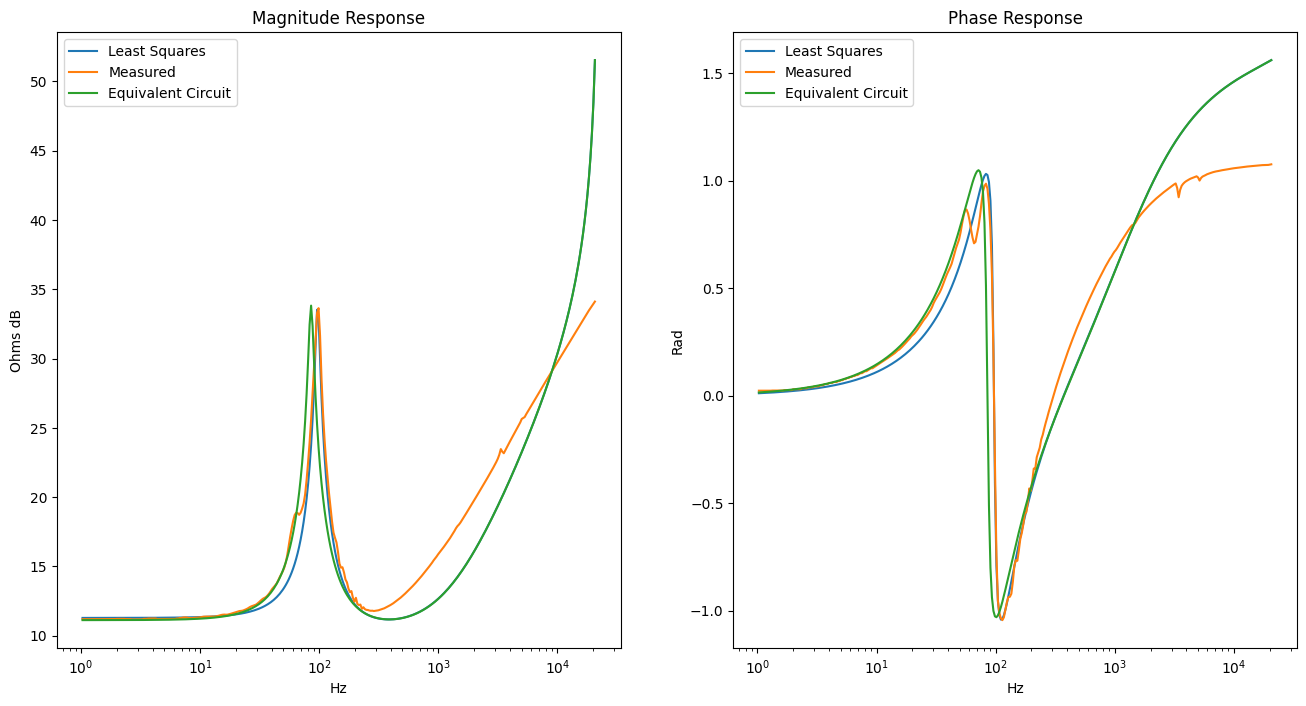

In [216]:
wz, hz = signal.freqz(model.b.detach().numpy(), model.a.detach().numpy(), worN = f, fs = fs)
plt.figure(figsize=(16, 8)) 
plt.subplot(1, 2, 1)
plt.plot(f, 20*np.log10(np.abs(hz)), label='Least Squares')
plt.plot(f, 20*np.log10(np.abs(h_measured)), label='Measured')
plt.plot(f, 20*np.log10(np.abs(hz_bilinear)), label='Equivalent Circuit')
plt.legend()
plt.xscale('log')
plt.title('Magnitude Response')
plt.xlabel("Hz")
plt.ylabel("Ohms dB")

plt.subplot(1, 2, 2)
plt.plot(f, np.angle(hz), label = 'Least Squares')
plt.plot(f, np.angle(h_measured), label='Measured')
plt.plot(f, np.angle(hz_bilinear), label='Equivalent Circuit')
plt.legend()
plt.xscale('log')
plt.title('Phase Response')
plt.xlabel("Hz")
plt.ylabel("Rad")